# Tekstverlies in de Middelnederlandse ridderepiek

In [192]:
import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline

## Data

In [193]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Aiol (1),H1
1,Aiol (2),H2
2,Alexanders Geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders Geesten,H3
4,Alexanders Geesten,H4
5,Alexanders Geesten,H5
6,Alexanders Geesten,H6
7,Arturs doet,"Den Haag, KB, 129 A 10"
8,Arturs doet,Croenen en Janssens
9,Aubri de Borgengoen,H7


In [194]:
mnl.groupby('text').size().sort_values(ascending=False).head()

text
Historie van Troyen       12
Madelgijs                 10
Roman van Limborch         9
Karel ende Elegast         7
Parthonopeus van Bloys     6
dtype: int64

In [195]:
labels, mnl_counts = np.unique(mnl.groupby('text').size(), return_counts=True)
print(mnl_counts)

[40 13  6  3  3  1  1  1  1  1]


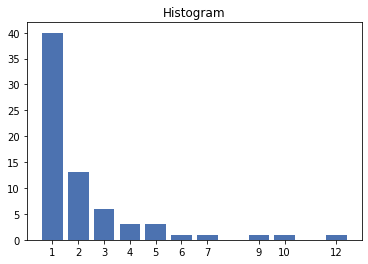

In [196]:
plt.bar(labels, mnl_counts, align='center')
plt.title('Histogram')
plt.gca().set_xticks(labels);

In [197]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unieke teksten:', species_richness(mnl.groupby('text').size()))
print('# unieke handschriften:', len(mnl))

# unieke teksten: 70
# unieke handschriften: 155


Waarom spreken we over *bias*? Omdat het belang of aandeel van de huidige observaties vrij consequent wordt over-schat: indien er nieuwe observaties worden bijgevonden, neemt het gewicht van de oude observaties immers proportioneel gesproken telkens wat af. We kennen bijvoorbeeld de volgende handschriften van de *Historie van Troyen*:

In [198]:
hvt = mnl[mnl['text'] == 'Historie van Troyen']
print(len(hvt))
hvt

12


,text,witness
123,Historie van Troyen,"Brussel, KBR, IV 927"
124,Historie van Troyen,"Brussel, KBR, 15.589-623"
125,Historie van Troyen,H106
126,Historie van Troyen,H107
127,Historie van Troyen,H108
128,Historie van Troyen,H109
129,Historie van Troyen,H110
130,Historie van Troyen,H111
131,Historie van Troyen,H112
132,Historie van Troyen,H113


Dit gebeurt er bijvoorbeeld met het relatieve belang van 'H112', als er een nieuw fragment opduikt (wat recent ook echt is gebeurd):

In [199]:
print('Proportioneel aandeel in de HvT-traditie:', 1 / len(hvt), 'vs', 1 / (len(hvt) + 1))
print('Proportioneel aandeel in de volledige traditie:', 1 / len(mnl), 'vs', 1 / (len(mnl) + 1))

Proportioneel aandeel in de HvT-traditie: 0.08333333333333333 vs 0.07692307692307693
Proportioneel aandeel in de volledige traditie: 0.0064516129032258064 vs 0.00641025641025641


## Jackknife

We willen dus de bias in deze dataset dus berekenen en gebruik om bepaalde tellingen, zoals het aantal soorten, op een verantwoord manier naar boven bij te stellen. Een eenvoudige, op dit moment al ietwat verouderde methode is de zogenaamde *first-order jackknife*, het 'knipmes van de eerste orde'. We itereren over alle handschriften en laten telkens één tekstgetuige weg, waarna we opnieuw de soortenrijkdom in de iets verkleinde dataset berekenen. Vervolgens nemen we gemiddelde van de verkregen waarden en we berekenen hoe ver we van de rijkdom van de volledige set verwijderd waren. Deze bias kan vervolgens verrekend worden door deze af te trekken van de oncorrigeerde soortenrijkdom:

In [200]:
def jackknife(data, conf_lvl = .95):
    jack_stat = species_richness(data)
    
    x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
    index = np.arange(x.shape[0])
    
    vals = []
    for i in range(x.shape[0]):
        t = x[index != i]
        vals.append(species_richness(np.bincount(t)))
    
    mean_jack_stat = np.mean(vals)
    bias = (x.shape[0]-1) * (mean_jack_stat - jack_stat)
    
    estimate = jack_stat - bias
    
    std_err = np.sqrt((x.shape[0] - 1) * np.mean((mean_jack_stat - vals) * (mean_jack_stat - vals), axis=0))    
    
    z_score = np.sqrt(2.0) * erfinv(conf_lvl)
    conf_interval = estimate + z_score * np.array((-std_err, std_err))
    
    return estimate, std_err, conf_interval

results = jackknife(mnl.groupby('text').size())
print('jackknife-estimate (order=1):', results[0])

jackknife-estimate (order=1): 109.74193548387203


Deze berekening is ook vrij eenvoudig analytisch uit te voeren:

In [201]:
num_per_text = mnl.groupby('text').size()

Het totale aantal unieke teksten is *t*:

In [202]:
t = species_richness(num_per_text)
t

70

Het aantal teksten dat slechts één keer voorkomt is *s*:

In [203]:
s = sum(num_per_text == 1)
s

40

Gemiddeld bekomen we dus deze afwijking:

In [209]:
mu = (((t - s) * t) + (s * (t - 1))) / t
mu

69.42857142857143

Zodat we de bias als volgt kunnen vaststellen:

In [210]:
bias = (t - 1) * (mu - t)
bias

-39.42857142857129

En als volgt kunnen we dit verrekenen:

In [211]:
t - bias

109.42857142857129